In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2
import sample_data

np.random.seed(0)
N_train = 5000; N_test = 1000
N = N_train + N_test
train = np.arange(N_train); test = np.arange(N_test) + N_train
n_min = 60; n_max = 60
#t_max = 50.

X, y = sample_data.synthetic_control(N, n_min, n_max, even=True, sigma=0.0)

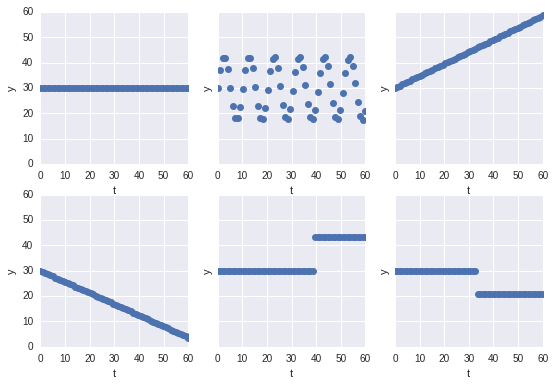

In [2]:
fig, ax = plt.subplots(2, 3, sharey=True)
for j in range(6):
    i = np.where(y == j)[0][0]
    ax.ravel()[j].plot(np.linspace(0, n_max, n_max), X[i], 'o')
#    ax.ravel()[j].plot(X[i][:, 0], X[i][:, 1], 'o')
    ax.ravel()[j].set(xlabel="t", ylabel="y")

In [3]:
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Activation, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import ProgbarLogger, TensorBoard

lstm_size = 128
lr = 1e-2

model = Sequential([
        LSTM(lstm_size, input_dim=1, input_length=n_max, return_sequences=True),
#        Dropout(0.25),
#        LSTM(128, return_sequences=True),
#        Dropout(0.5),
        TimeDistributed(Dense(1)),
        Activation('linear'),
])
adam = Adam(lr=lr)
model.compile(optimizer=adam, loss='mse', metrics=[])#'accuracy'])

Using TensorFlow backend.


In [4]:
#!rm -rf /tmp/keras_logs/*

In [5]:
import os

run = "auto_even_{}_{:1.0e}_nodrop".format(lstm_size, lr).replace('e-', 'm')
print(run)
log_dir = '/tmp/keras_logs/{}'.format(run)
!rm -rf $log_dir
#if os.path.exists(log_dir):
#    raise Exception("Log directory already exists, not overwriting")
hist = model.fit(X[train], X[train], nb_epoch=50, batch_size=200,
                 validation_split=0.2,
                 callbacks=[ProgbarLogger(), TensorBoard(log_dir=log_dir)])

auto_even_128_1m02_nodrop
Train on 5000 samples, validate on 1000 samples
Epoch 1/50
Epoch 1/50
5000/5000 [==============================] - 5s - loss: 404.7634 - val_loss: 95.0024
Epoch 2/50
Epoch 2/50
5000/5000 [==============================] - 2s - loss: 42.7379 - val_loss: 15.9970
Epoch 3/50
Epoch 3/50
5000/5000 [==============================] - 2s - loss: 9.9797 - val_loss: 5.9436
Epoch 4/50
Epoch 4/50
5000/5000 [==============================] - 2s - loss: 4.2532 - val_loss: 3.0625
Epoch 5/50
Epoch 5/50
5000/5000 [==============================] - 2s - loss: 2.4290 - val_loss: 1.9034
Epoch 6/50
Epoch 6/50
5000/5000 [==============================] - 2s - loss: 1.6117 - val_loss: 1.3549
Epoch 7/50
Epoch 7/50
5000/5000 [==============================] - 2s - loss: 1.1827 - val_loss: 1.0280
Epoch 8/50
Epoch 8/50
5000/5000 [==============================] - 3s - loss: 0.9439 - val_loss: 0.8314
Epoch 9/50
Epoch 9/50
5000/5000 [==============================] - 3s - loss: 0.7311 - va

In [6]:
%%time
pred = model.predict(X[test])

CPU times: user 1.67 s, sys: 270 ms, total: 1.94 s
Wall time: 1.27 s


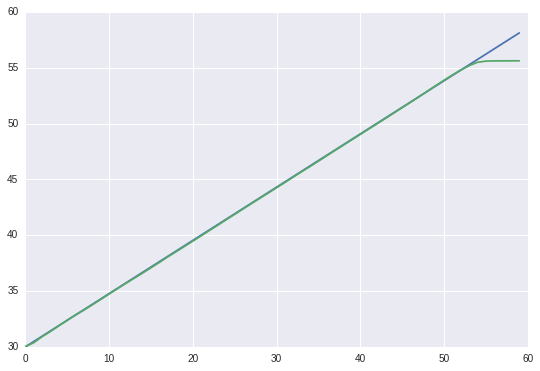

In [7]:
plt.plot(np.arange(n_max), X[test[0]])
plt.plot(np.arange(n_max), pred[0])